In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import timm  # For DINO models
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import time
import torch.optim as optim
from tqdm import tqdm

In [24]:
!pip install timm


In [3]:
pip install umap-learn

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
Using cached umap_learn-0.5.7-py3-none-any.whl (88 kB)
Using cached pynndescent-0.5.13-py3-none-any.whl (56 kB)
Note: you may need to restart the kernel to use updated packages.


## Using vit_base_patch16_224_dino

In [4]:
import torch
import timm
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import DataLoader

# Load the pre-trained DINO model
model = timm.create_model('vit_base_patch16_224_dino', pretrained=True)

# Remove the classification head (for feature extraction)
model.head = nn.Identity()

# Move model to GPU if available
model = model.cuda() if torch.cuda.is_available() else model

# Put model in evaluation mode
model.eval()


/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_dino to current vit_base_patch16_224.dino.
  model = create_fn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [5]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

train_dataset = ImageFolder('/kaggle/input/opa-quality/Sampled/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

In [6]:
device= 'cuda'

def extract_features(model, dataloader, device):
    features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            features = model(images)  # Forward pass, features from the penultimate layer
            features_list.append(features.cpu())  # Move to CPU for storing
            labels_list.append(labels.cpu())
    features = torch.cat(features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)
    return features, labels

# Example: Using a dataloader to get features
# Assuming 'test_loader' is your DataLoader
# Replace `device` with "cuda" if you are using GPU

# Extract features
features, labels = extract_features(model, train_loader, device)

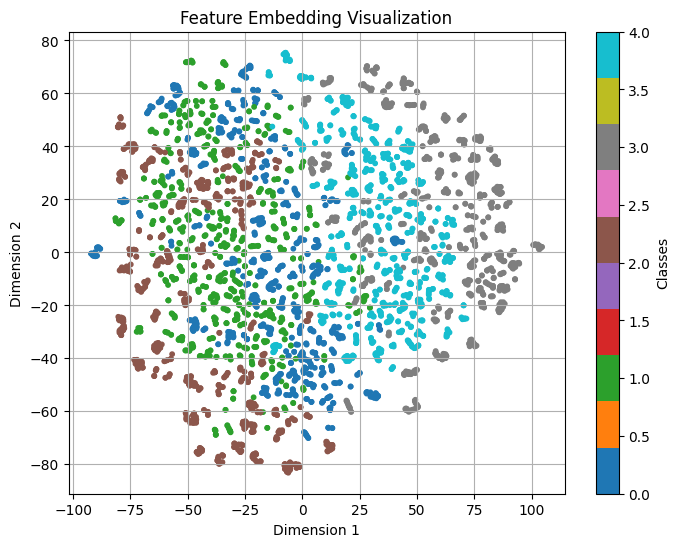

In [13]:
visualize_embeddings(model, train_loader, num_samples=5000)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


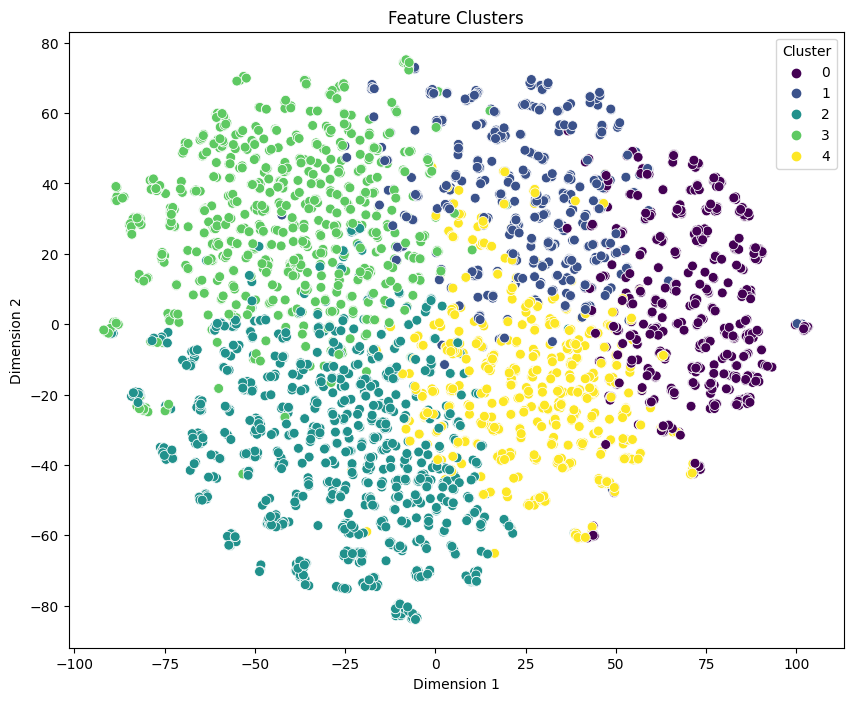

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import seaborn as sns

# Perform clustering
def perform_clustering(features, n_clusters=5):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(features)
    return cluster_labels, kmeans

# Reduce dimensionality for visualization
def reduce_dimensionality(features, n_components=2):
    tsne = TSNE(n_components=n_components, random_state=42)
    reduced_features = tsne.fit_transform(features)
    return reduced_features

# Visualize clusters
def visualize_clusters(reduced_features, cluster_labels, title="Feature Clusters"):
    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        x=reduced_features[:, 0], 
        y=reduced_features[:, 1], 
        hue=cluster_labels, 
        palette="viridis", 
        s=50
    )
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Cluster")
    plt.show()

# Main workflow
def cluster_and_visualize(features, n_clusters=5):
    features_np = features.numpy()  # Convert to NumPy array if needed
    cluster_labels, kmeans = perform_clustering(features_np, n_clusters=n_clusters)
    reduced_features = reduce_dimensionality(features_np, n_components=2)
    visualize_clusters(reduced_features, cluster_labels)

# Call the clustering and visualization function
# Assumes 'features' is a PyTorch tensor of shape [num_samples, feature_dim]
cluster_and_visualize(features)


In [10]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from scipy.stats import mode

# Function to evaluate clustering
def evaluate_clustering(cluster_labels, true_labels):
    ari = adjusted_rand_score(true_labels, cluster_labels)
    nmi = normalized_mutual_info_score(true_labels, cluster_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.4f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
    return ari, nmi




# Example: Evaluate clustering
cluster_labels, kmeans = perform_clustering(features.numpy(), n_clusters=5)
ari, nmi = evaluate_clustering(cluster_labels, labels.numpy())



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Adjusted Rand Index (ARI): 0.2266
Normalized Mutual Information (NMI): 0.3331


Fine Tune the model

In [3]:
# Define model
model = timm.create_model('vit_base_patch16_224_dino', pretrained=True)

# Freeze all layers except the last transformer blocks and the head
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 5 transformer blocks
for param in model.blocks[-2:].parameters():  # Unfreeze the last 5 transformer blocks
    param.requires_grad = True

# Also unfreeze the classifier head (or Identity layer in this case)
for param in model.head.parameters():
    param.requires_grad = True

# Remove the classification head for self-supervised learning
model.head = nn.Identity()

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)  # Wrap the model with DataParallel


model = model.cuda()  # Move model to GPU

# Define loss function and optimizer
criterion = nn.MSELoss()  # Mean Squared Error for self-distillation
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)




/usr/local/lib/python3.10/dist-packages/timm/models/_factory.py:117: UserWarning: Mapping deprecated model name vit_base_patch16_224_dino to current vit_base_patch16_224.dino.
  model = create_fn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Using 2 GPUs!


In [6]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    start_time = time.time()  # Track time for this epoch

    print(f"Epoch {epoch+1}/{epochs}")
    with tqdm(total=len(train_loader), desc="Training", unit="batch") as pbar:
        for images, _ in train_loader:  # No need for labels in self-supervised learning
            images = images.cuda()

            # Forward pass
            outputs = model(images)

            # Self-distillation loss: Compare the model output to its own previous output
            soft_target = outputs.detach()  # This detaches the gradient for self-supervised distillation

            # Compute the loss (using MSE loss between outputs and soft targets)
            loss = criterion(outputs, soft_target)

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Update progress bar
            pbar.update(1)
            pbar.set_postfix({"Batch Loss": loss.item()})

    # Calculate metrics after the epoch
    avg_loss = running_loss / len(train_loader)
    epoch_time = time.time() - start_time

    print(f"Epoch {epoch+1} Completed:")
    print(f"  Average Loss: {avg_loss:.4f}")
    print(f"  Time taken: {epoch_time:.2f} seconds\n")

Epoch 1/10


Training: 100%|██████████| 155/155 [00:54<00:00,  2.85batch/s, Batch Loss=0]


Epoch 1 Completed:
  Average Loss: 0.0000
  Time taken: 54.31 seconds

Epoch 2/10


Training: 100%|██████████| 155/155 [00:58<00:00,  2.66batch/s, Batch Loss=0]


Epoch 2 Completed:
  Average Loss: 0.0000
  Time taken: 58.37 seconds

Epoch 3/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.71batch/s, Batch Loss=0]


Epoch 3 Completed:
  Average Loss: 0.0000
  Time taken: 57.30 seconds

Epoch 4/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.67batch/s, Batch Loss=0]


Epoch 4 Completed:
  Average Loss: 0.0000
  Time taken: 57.96 seconds

Epoch 5/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.68batch/s, Batch Loss=0]


Epoch 5 Completed:
  Average Loss: 0.0000
  Time taken: 57.73 seconds

Epoch 6/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.70batch/s, Batch Loss=0]


Epoch 6 Completed:
  Average Loss: 0.0000
  Time taken: 57.31 seconds

Epoch 7/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.70batch/s, Batch Loss=0]


Epoch 7 Completed:
  Average Loss: 0.0000
  Time taken: 57.34 seconds

Epoch 8/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.71batch/s, Batch Loss=0]


Epoch 8 Completed:
  Average Loss: 0.0000
  Time taken: 57.26 seconds

Epoch 9/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.72batch/s, Batch Loss=0]


Epoch 9 Completed:
  Average Loss: 0.0000
  Time taken: 57.08 seconds

Epoch 10/10


Training: 100%|██████████| 155/155 [00:57<00:00,  2.72batch/s, Batch Loss=0]

Epoch 10 Completed:
  Average Loss: 0.0000
  Time taken: 57.08 seconds



# Functions for Dimensionality Reduction and Visualization

In [39]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
#import umap.umap_ as umap 
from random import sample


In [3]:
# Function to visualize feature embeddings
def visualize_embeddings(model, dataloader, num_samples=200):
    model.eval()
    features, labels = [], []

    # Extract features for a subset of the dataset
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.cuda()
            outputs = model(images)  # Forward pass
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
            if len(features) * len(images) >= num_samples:
                break

    # Flatten lists
    features = np.vstack(features)[:num_samples]
    labels = np.hstack(labels)[:num_samples]

    # Use PCA or t-SNE to reduce dimensionality
    #reduced_features = PCA(n_components=2).fit_transform(features)
    # Alternatively, use t-SNE for better separation
    reduced_features = TSNE(n_components=2).fit_transform(features)

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap="tab10", s=10)
    plt.colorbar(scatter, label="Classes")
    plt.title("Feature Embedding Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.show()

# Call the function to visualize

In [4]:
def visualize_embeddings_3d(model, dataloader, num_samples=200):
    model.eval()
    features, labels = [], []

    # Extract features for a subset of the dataset
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.cuda()
            outputs = model(images)  # Forward pass
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
            if len(features) * len(images) >= num_samples:
                break

    # Flatten lists
    features = np.vstack(features)[:num_samples]
    labels = np.hstack(labels)[:num_samples]

    # Use PCA or t-SNE to reduce dimensionality to 3D
    reduced_features = TSNE(n_components=3).fit_transform(features)
    # For PCA, use: reduced_features = PCA(n_components=3).fit_transform(features)

    # 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        reduced_features[:, 2],
        c=labels,
        cmap="tab10",
        s=15
    )
    ax.set_title("3D Feature Embedding Visualization")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.colorbar(scatter, label="Classes")
    plt.show()

In [22]:
def visualize_embeddings_2d_umap_random(model, dataloader, num_samples=200):
    model.eval()
    features, labels = [], []
    
    # Create a list of all dataset indices
    all_samples = []
    all_labels = []

    # Extract features and labels for the entire dataset
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.cuda()
            outputs = model(images)  # Forward pass
            all_samples.append(outputs.cpu().numpy())
            all_labels.append(lbls.numpy())

    # Flatten the accumulated samples and labels
    all_samples = np.vstack(all_samples)
    all_labels = np.hstack(all_labels)

    # Randomly sample `num_samples` from the dataset
    indices = sample(range(len(all_samples)), num_samples)
    selected_features = all_samples[indices]
    selected_labels = all_labels[indices]

    # Apply UMAP to reduce dimensionality to 2D
    reducer = umap.UMAP(n_components=2, random_state=42)
    reduced_features = reducer.fit_transform(selected_features)

    # 2D scatter plot
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        c=selected_labels,
        cmap="tab10",
        s=15
    )
    plt.title("2D Feature Embedding Visualization (UMAP)")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.colorbar(scatter, label="Classes")
    plt.show()

In [24]:
# Function to visualize 3D feature embeddings using UMAP
def visualize_embeddings_3d_umap(model, dataloader, num_samples=200):
    model.eval()
    features, labels = [], []

    # Extract features for a subset of the dataset
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.cuda()
            outputs = model(images)  # Forward pass
            features.append(outputs.cpu().numpy())
            labels.append(lbls.numpy())
            if len(features) * len(images) >= num_samples:
                break

    # Flatten lists
    features = np.vstack(features)[:num_samples]
    labels = np.hstack(labels)[:num_samples]

    # Apply UMAP to reduce dimensionality to 3D
    reducer = umap.UMAP(n_components=3, random_state=42)
    reduced_features = reducer.fit_transform(features)

    # 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        reduced_features[:, 0],
        reduced_features[:, 1],
        reduced_features[:, 2],
        c=labels,
        cmap="tab10",
        s=15
    )
    ax.set_title("3D Feature Embedding Visualization (UMAP)")
    ax.set_xlabel("Dimension 1")
    ax.set_ylabel("Dimension 2")
    ax.set_zlabel("Dimension 3")
    plt.colorbar(scatter, label="Classes")
    plt.show()


In [37]:
# Assuming you are using a dataset like ImageFolder
class_to_idx = train_loader.dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

# Print the class name mappings
print("Class Name Mappings:")
for idx, class_name in idx_to_class.items():
    print(f"{idx}: {class_name}")


Class Name Mappings:
0: 1200-1450
1: 1450-1700
2: 1700-1950
3: 700-950
4: 950-1200


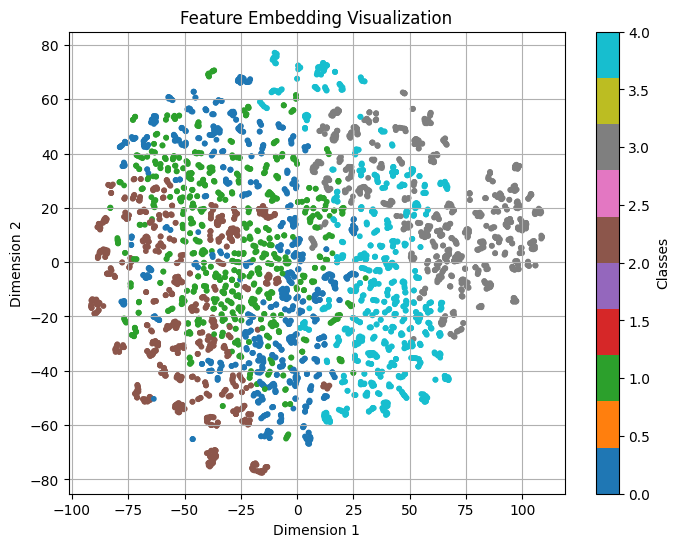

In [18]:
visualize_embeddings(model, train_loader, num_samples=5000)

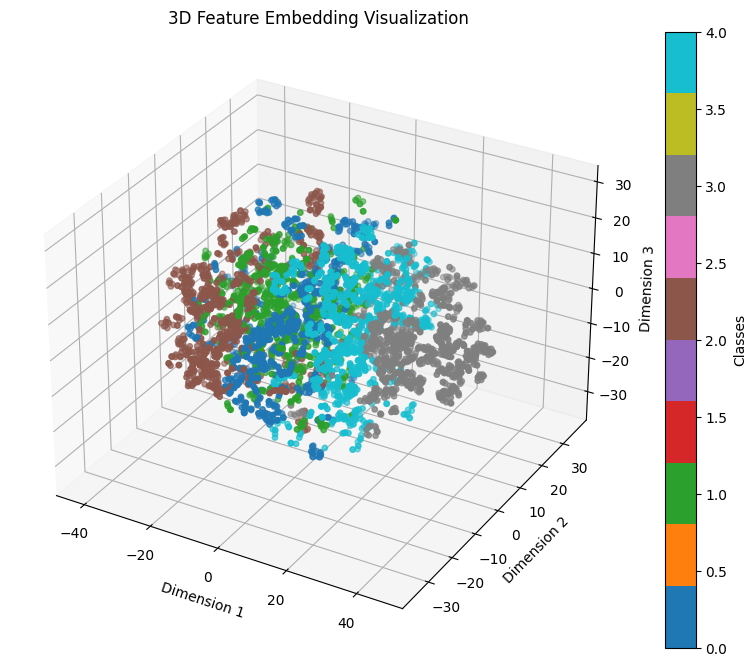

In [20]:
visualize_embeddings_3d(model, train_loader, num_samples=5000)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


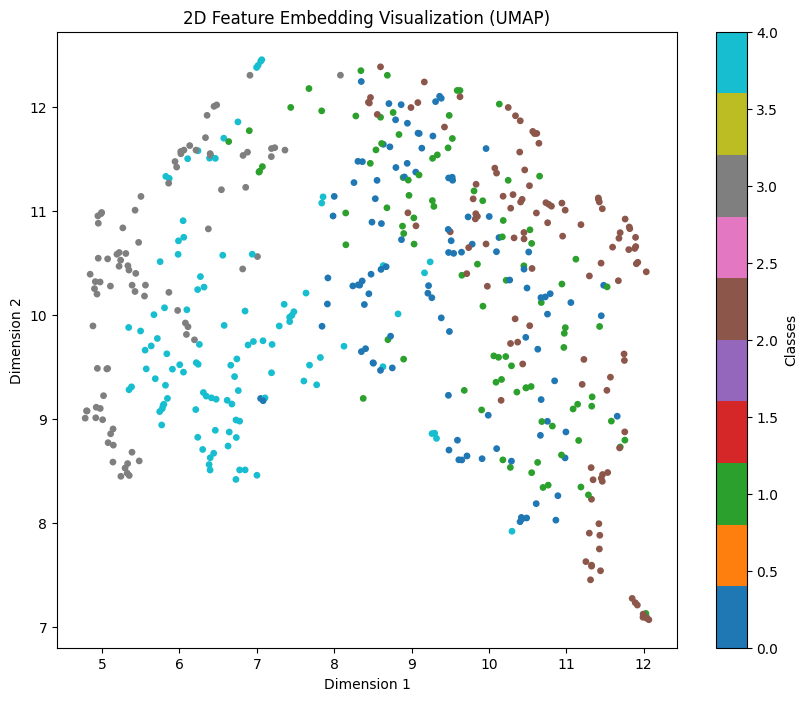

In [35]:
visualize_embeddings_2d_umap_random(model, train_loader, num_samples=500)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


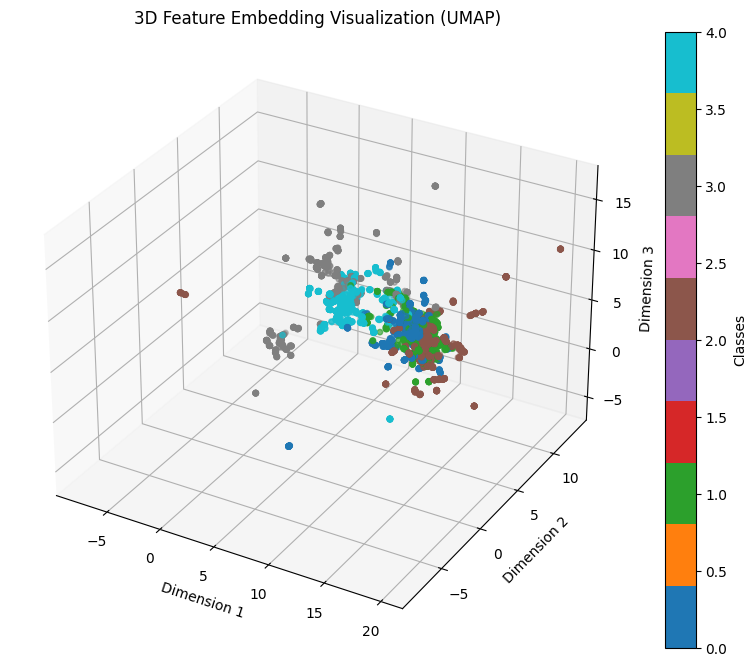

In [31]:
visualize_embeddings_3d_umap(model, train_loader, num_samples=5000)

## Using DINOv2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load the pre-trained DinoV2 model
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')

# Put model in evaluation mode
dinov2_model.eval()

# Define a transform for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalization for DinoV2
])

# Load dataset
train_dataset = ImageFolder('/kaggle/input/opa-quality/Sampled/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)

# Move the model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dinov2_model = dinov2_model.to(device)

# Define the feature extraction function
def extract_features_dinov2(model, dataloader, device):
    cls_features_list = []
    patch_features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass through the model
            output = model.forward_features(images)  # Extract features
            cls_tokens = output['x_norm_clstoken']  # CLS tokens
            patch_tokens = output['x_norm_patchtokens']  # Patch tokens

            cls_features_list.append(cls_tokens.cpu())
            patch_features_list.append(patch_tokens.cpu())
            labels_list.append(labels.cpu())

    # Concatenate all features and labels
    cls_features = torch.cat(cls_features_list, dim=0)
    patch_features = torch.cat(patch_features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    return cls_features, patch_features, labels

# Extract features using the train_loader
cls_features, patch_features, labels = extract_features_dinov2(dinov2_model, train_loader, device)

# Save features and labels to disk (optional)
torch.save(cls_features, 'cls_features.pt')
torch.save(patch_features, 'patch_features.pt')
torch.save(labels, 'labels.pt')

# Verify shapes of the features
print("CLS Features Shape:", cls_features.shape)  # Expected: [num_images, 768]
print("Patch Features Shape:", patch_features.shape)  # Expected: [num_images, num_patches, 768]
print("Labels Shape:", labels.shape)  # Expected: [num_images]


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_reg4_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_reg4_pretrain.pth
100%|██████████| 84.2M/84.2M [00:03<00:00, 26.0MB/s]


CLS Features Shape: torch.Size([4955, 384])
Patch Features Shape: torch.Size([4955, 256, 384])
Labels Shape: torch.Size([4955])


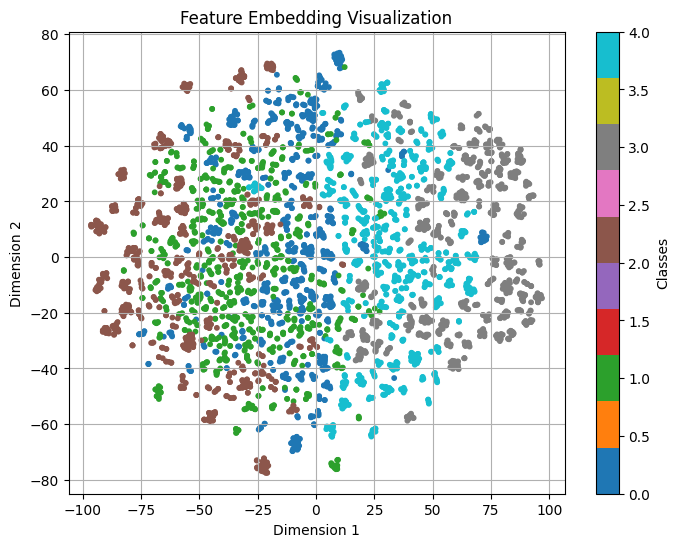

In [11]:
visualize_embeddings(dinov2_model, train_loader, num_samples=5000)

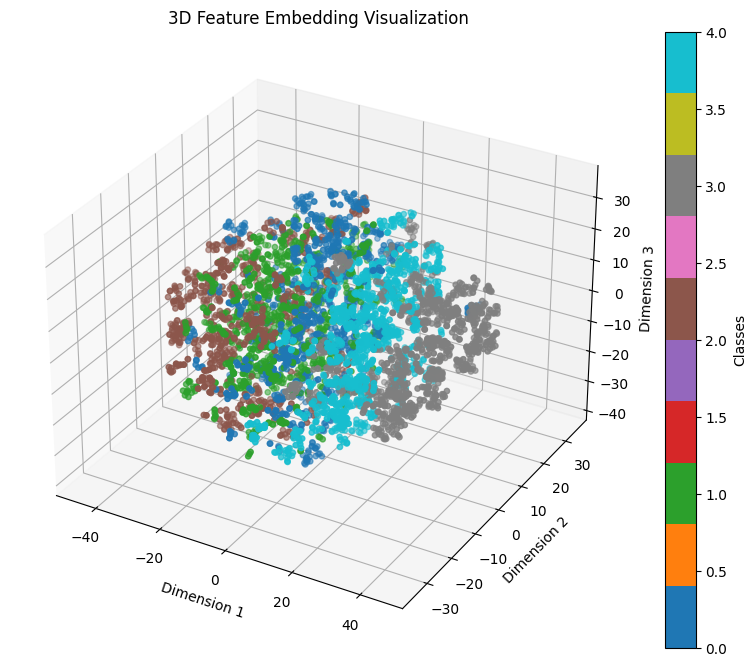

In [13]:
visualize_embeddings_3d(dinov2_model, train_loader, num_samples=5000)

In [37]:
# Function to visualize feature embeddings
def visualize_embeddings_cls(model, dataloader, num_samples=200):
    model.eval()
    cls_features, labels = [], []

    # Extract features for a subset of the dataset
    with torch.no_grad():
        for images, lbls in dataloader:
            images = images.cuda()
            output = model.forward_features(images)  # Forward pass through model to get features
            cls_tokens = output['x_norm_clstoken']  # Extract CLS token features
            cls_features.append(cls_tokens.cpu().numpy())  # Store the features
            labels.append(lbls.numpy())
            if len(cls_features) * len(images) >= num_samples:
                break

    # Flatten lists
    cls_features = np.vstack(cls_features)[:num_samples]  # Limit to num_samples
    labels = np.hstack(labels)[:num_samples]

    # Use PCA or t-SNE to reduce dimensionality
    reduced_features = TSNE(n_components=2).fit_transform(cls_features)

    # Plot the embeddings
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=labels, cmap="tab10", s=10)
    plt.colorbar(scatter, label="Classes")
    plt.title("Feature Embedding Visualization")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid()
    plt.show()

# Call the function to visualize


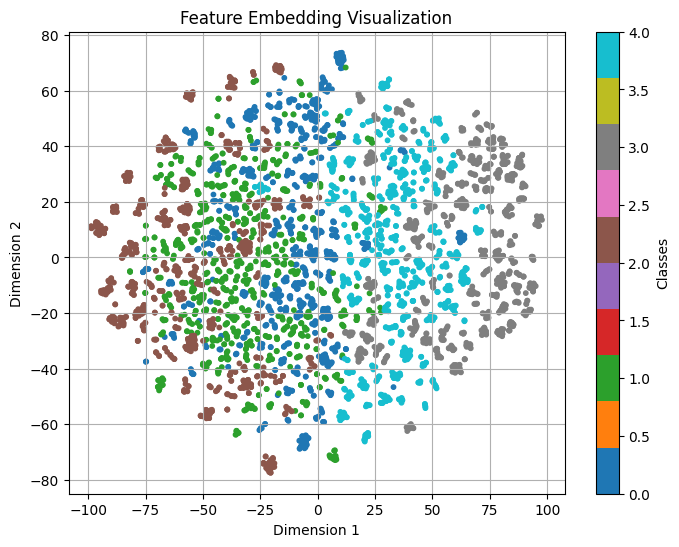

In [18]:
visualize_embeddings_cls(dinov2_model, train_loader, num_samples=5000)

In [36]:
# Load the pre-trained DINO model
model = timm.create_model('davit_base_fl', pretrained=True)

# Remove the classification head (for feature extraction)
model.head = nn.Identity()



# Put model in evaluation mode
model.eval()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
byol_model = byol_model.to(device)


## Using Autoencoders on features extracted by DINO

In [31]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Load the pre-trained DinoV2 model
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')

# Put model in evaluation mode
dinov2_model.eval()

# Define a transform for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalization for DinoV2
])

# Load dataset
train_dataset = ImageFolder('/kaggle/input/opa-quality/Sampled/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False, num_workers=2)

# Move the model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dinov2_model = dinov2_model.to(device)

# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder to reduce features to 10 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(384, 512),  # Correct input size to match DINOv2's CLS feature size (384)
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # Output reduced to 10 dimensions
        )

    def forward(self, x):
        return self.encoder(x)

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

# Define the feature extraction function
def extract_features_dinov2(model, dataloader, device, autoencoder):
    cls_features_list = []
    with torch.no_grad():
        for images, _ in dataloader:  # Ignoring labels
            images = images.to(device)

            # Forward pass through the model
            output = model.forward_features(images)  # Extract features
            cls_tokens = output['x_norm_clstoken']  # CLS tokens

            # Pass the cls_tokens through the autoencoder to get a 10-dimensional vector
            reduced_features = autoencoder(cls_tokens)

            cls_features_list.append(reduced_features.cpu())  # Store the reduced features

    # Concatenate all features
    cls_features = torch.cat(cls_features_list, dim=0)

    return cls_features

# Extract features using the train_loader
#cls_features = extract_features_dinov2(dinov2_model, train_loader, device, autoencoder)

# Save features to disk (optional)
#torch.save(cls_features, 'reduced_cls_features.pt')

# Verify shape of the features
print("Reduced CLS Features Shape:", cls_features.shape)  # Expected: [num_images, 10]


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


Reduced CLS Features Shape: torch.Size([4955, 2])


In [4]:
print(cls_features)

tensor([[-0.2808,  0.0281, -0.1254],
        [-0.2585, -0.0363, -0.2047],
        [-0.3295,  0.0273, -0.0068],
        ...,
        [-0.3567,  0.0448, -0.1687],
        [-0.2717,  0.0426, -0.1227],
        [-0.3388, -0.0077, -0.1088]])


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
# Visualize the 3D feature vectors using matplotlib
def visualize_3d_features(features):
    # Prepare the data
    x = features[:, 0].numpy()
    y = features[:, 1].numpy()
    z = features[:, 2].numpy()

    # Create a 3D scatter plot
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=z, cmap='viridis', marker='o')

    # Set labels for axes
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')
    ax.set_title('3D Visualization of Reduced Feature Vectors')

    # Show the plot
    plt.show()



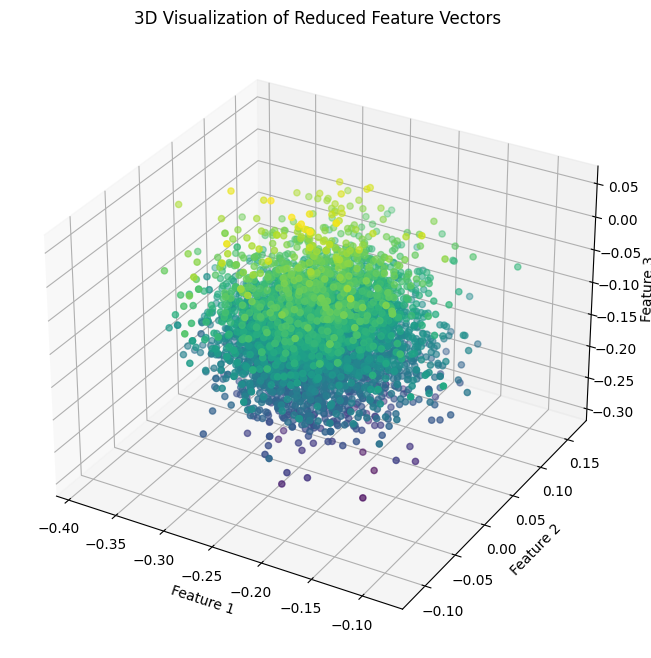

In [7]:
# Visualize the reduced 3D feature vectors
visualize_3d_features(cls_features)

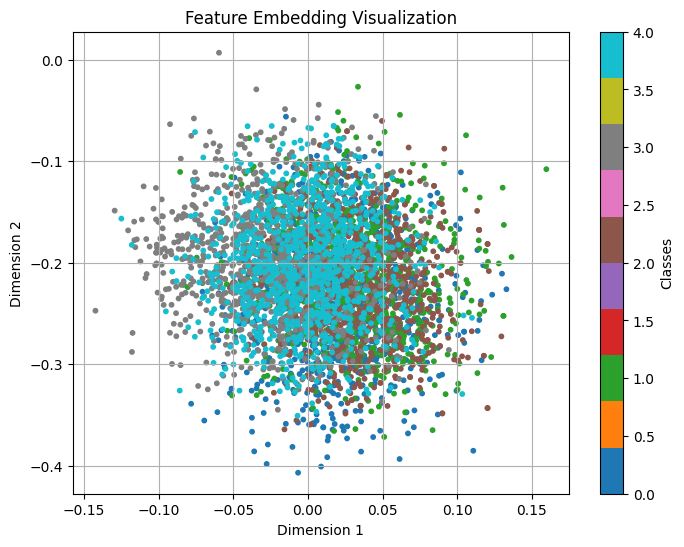

In [30]:
extract_features_dinov2_vis(dinov2_model, train_loader, device, autoencoder)

## Training the AE

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [11]:
# Load the pre-trained DinoV2 model
dinov2_model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')

# Put model in evaluation mode
dinov2_model.eval()

# Move the model to GPU if available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
dinov2_model = dinov2_model.to(device)


Using cache found in /root/.cache/torch/hub/facebookresearch_dinov2_main


In [15]:
# Define a transform for preprocessing the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match model input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),  # Normalization for DinoV2
])

# Load dataset
train_dataset = ImageFolder('/kaggle/input/opa-quality/Sampled/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)

val_dataset = ImageFolder('/kaggle/input/opa-quality/Sampled/val', transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)


In [4]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder to reduce features to 2 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(384, 512),  # Match DINOv2 CLS token size
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Reduce to 2 dimensions
        )
        # Decoder to reconstruct features (optional, for training)
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 384)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)


In [12]:
def train_autoencoder(autoencoder, dinov2_model, dataloader, device, optimizer, criterion, epochs=10, threshold=0.3):
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_samples = 0
        total_samples = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for images, _ in pbar:  # We don't need labels for the autoencoder
            images = images.to(device)

            # Extract CLS tokens from the DINOv2 model
            with torch.no_grad():
                output = dinov2_model.forward_features(images)
                cls_tokens = output['x_norm_clstoken']

            # Forward pass through the autoencoder
            optimizer.zero_grad()
            encoded, reconstructed = autoencoder(cls_tokens)
            loss = criterion(reconstructed, cls_tokens)  # Compare reconstructed features with input
            loss.backward()
            optimizer.step()

            # Update progress
            pbar.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

            # Calculate reconstruction error
            reconstruction_error = torch.mean((reconstructed - cls_tokens) ** 2, dim=1)
            
            # Debug: Print reconstruction errors for the first epoch
            if epoch == 0 and total_samples == 0:
                print("Reconstruction Errors (Sample):", reconstruction_error[:5].detach().cpu().numpy())

            # Update accuracy
            correct_samples += (reconstruction_error < threshold).sum().item()
            total_samples += images.size(0)

        # Compute epoch accuracy
        accuracy = (correct_samples / total_samples) * 100

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss / len(dataloader):.4f}, Accuracy: {accuracy:.2f}%")



# Define optimizer and loss function
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)  # Optimizer
criterion = nn.MSELoss()  # Loss function

# Train the autoencoder
train_autoencoder(autoencoder, dinov2_model, train_loader, device, optimizer, criterion, epochs=20)


Epoch 1/20:   1%|▏         | 2/155 [00:00<00:47,  3.23it/s, loss=0.263]

Reconstruction Errors (Sample): [0.25075197 0.19302699 0.21855295 0.26730663 0.2837859 ]


Epoch 1/20 - Loss: 0.2410, Accuracy: 83.33%


Epoch 2/20 - Loss: 0.2371, Accuracy: 84.58%


Epoch 3/20 - Loss: 0.2340, Accuracy: 85.35%


Epoch 4/20 - Loss: 0.2323, Accuracy: 85.69%


Epoch 5/20 - Loss: 0.2310, Accuracy: 85.89%


Epoch 6/20 - Loss: 0.2286, Accuracy: 86.40%


Epoch 7/20 - Loss: 0.2275, Accuracy: 87.33%


Epoch 8/20 - Loss: 0.2267, Accuracy: 87.16%


Epoch 9/20 - Loss: 0.2246, Accuracy: 87.83%


Epoch 10/20 - Loss: 0.2240, Accuracy: 88.07%


Epoch 11/20 - Loss: 0.2230, Accuracy: 88.31%


Epoch 12/20 - Loss: 0.2221, Accuracy: 88.70%


Epoch 13/20 - Loss: 0.2206, Accuracy: 89.36%


Epoch 14/20 - Loss: 0.2205, Accuracy: 89.06%


Epoch 15/20 - Loss: 0.2194, Accuracy: 89.77%


Epoch 16/20 - Loss: 0.2192, Accuracy: 89.67%


Epoch 17/20 - Loss: 0.2178, Accuracy: 89.93%


Epoch 18/20 - Loss: 0.2173, Accuracy: 90.31%


Epoch 19/20 - Loss: 0.2152, Accuracy: 90.60%


Epoch 20/20 - Loss: 0.2147, Accuracy: 90.96%


In [13]:
# Define the feature extraction function
def extract_features_with_labels_dinov2(model, dataloader, device, autoencoder):
    cls_features_list = []
    labels_list = []
    with torch.no_grad():
        for images, labels in dataloader:  # Include labels
            images = images.to(device)

            # Forward pass through the model
            output = model.forward_features(images)
            cls_tokens = output['x_norm_clstoken']

            # Pass the cls_tokens through the autoencoder to get reduced features
            reduced_features, _ = autoencoder(cls_tokens)

            cls_features_list.append(reduced_features.cpu())  # Store the reduced features
            labels_list.append(labels.cpu())  # Store the corresponding labels

    # Concatenate all features and labels
    cls_features = torch.cat(cls_features_list, dim=0)
    labels = torch.cat(labels_list, dim=0)

    return cls_features, labels

# Extract features and labels
cls_features, labels = extract_features_with_labels_dinov2(dinov2_model, train_loader, device, autoencoder)


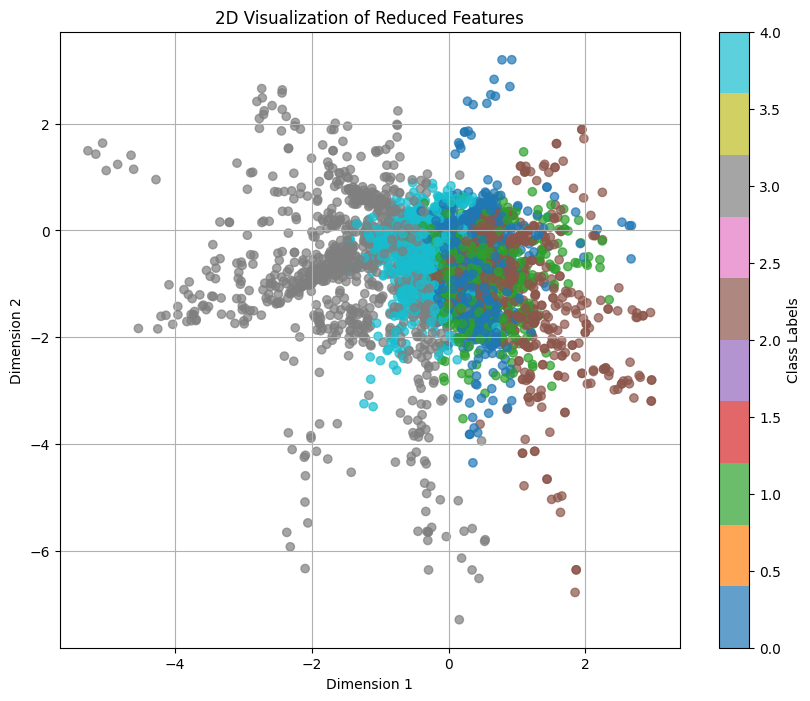

In [14]:
# Convert to NumPy
cls_features_np = cls_features.numpy()
labels_np = labels.numpy()

# Plot the reduced 2D features
plt.figure(figsize=(10, 8))
scatter = plt.scatter(cls_features_np[:, 0], cls_features_np[:, 1], c=labels_np, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title('2D Visualization of Reduced Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()


In [19]:
cls_features, labels = extract_features_with_labels_dinov2(dinov2_model, val_loader, device, autoencoder)

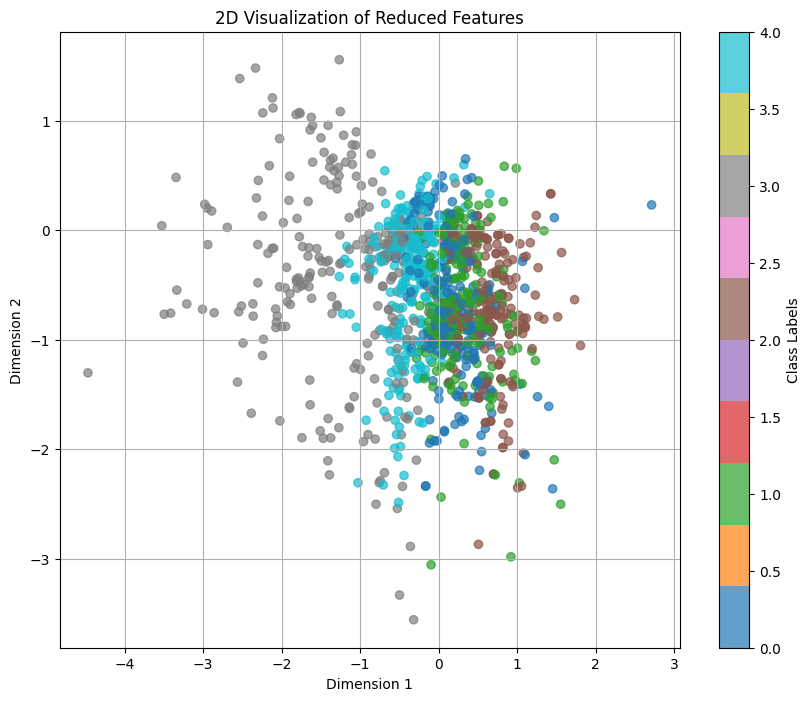

In [20]:
# Convert to NumPy
cls_features_np = cls_features.numpy()
labels_np = labels.numpy()

# Plot the reduced 2D features
plt.figure(figsize=(10, 8))
scatter = plt.scatter(cls_features_np[:, 0], cls_features_np[:, 1], c=labels_np, cmap='tab10', alpha=0.7)
plt.colorbar(scatter, label='Class Labels')
plt.title('2D Visualization of Reduced Features')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.grid(True)
plt.show()

In [34]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder to reduce features to 2 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(384, 512),  # Match DINOv2 CLS token size
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 3)  # Reduce to 2 dimensions
        )
        # Decoder to reconstruct features (optional, for training)
        self.decoder = nn.Sequential(
            nn.Linear(3, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 384)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

In [35]:
def train_autoencoder(autoencoder, dinov2_model, dataloader, device, optimizer, criterion, epochs=10, threshold=0.3):
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_samples = 0
        total_samples = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for images, _ in pbar:  # We don't need labels for the autoencoder
            images = images.to(device)

            # Extract CLS tokens from the DINOv2 model
            with torch.no_grad():
                output = dinov2_model.forward_features(images)
                cls_tokens = output['x_norm_clstoken']

            # Forward pass through the autoencoder
            optimizer.zero_grad()
            encoded, reconstructed = autoencoder(cls_tokens)
            loss = criterion(reconstructed, cls_tokens)  # Compare reconstructed features with input
            loss.backward()
            optimizer.step()

            # Update progress
            pbar.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

            # Calculate reconstruction error
            reconstruction_error = torch.mean((reconstructed - cls_tokens) ** 2, dim=1)
            
            # Debug: Print reconstruction errors for the first epoch
            if epoch == 0 and total_samples == 0:
                print("Reconstruction Errors (Sample):", reconstruction_error[:5].detach().cpu().numpy())

            # Update accuracy
            correct_samples += (reconstruction_error < threshold).sum().item()
            total_samples += images.size(0)

        # Compute epoch accuracy
        accuracy = (correct_samples / total_samples) * 100

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss / len(dataloader):.4f}, Accuracy: {accuracy:.2f}%")



# Define optimizer and loss function
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)  # Optimizer
criterion = nn.MSELoss()  # Loss function

# Train the autoencoder
train_autoencoder(autoencoder, dinov2_model, train_loader, device, optimizer, criterion, epochs=20)


Epoch 1/20:   1%|▏         | 2/155 [00:00<00:51,  2.99it/s, loss=1.65]

Reconstruction Errors (Sample): [1.7215748 1.6833274 1.6415422 1.7527256 1.6911681]


Epoch 1/20 - Loss: 0.3577, Accuracy: 51.81%


Epoch 2/20 - Loss: 0.2462, Accuracy: 80.61%


Epoch 3/20 - Loss: 0.2408, Accuracy: 82.56%


Epoch 4/20 - Loss: 0.2304, Accuracy: 86.46%


Epoch 5/20 - Loss: 0.2234, Accuracy: 88.60%


Epoch 6/20 - Loss: 0.2202, Accuracy: 89.40%


Epoch 7/20 - Loss: 0.2174, Accuracy: 90.45%


Epoch 8/20 - Loss: 0.2143, Accuracy: 91.00%


Epoch 9/20 - Loss: 0.2122, Accuracy: 91.56%


Epoch 10/20 - Loss: 0.2099, Accuracy: 92.13%


Epoch 11/20 - Loss: 0.2084, Accuracy: 92.63%


Epoch 12/20 - Loss: 0.2063, Accuracy: 93.10%


Epoch 13/20 - Loss: 0.2052, Accuracy: 93.46%


Epoch 14/20 - Loss: 0.2035, Accuracy: 93.58%


Epoch 15/20 - Loss: 0.2030, Accuracy: 93.74%


Epoch 16/20 - Loss: 0.2017, Accuracy: 93.86%


Epoch 17/20 - Loss: 0.2004, Accuracy: 94.21%


Epoch 18/20 - Loss: 0.1997, Accuracy: 94.33%


Epoch 19/20 - Loss: 0.1989, Accuracy: 94.75%


Epoch 20/20 - Loss: 0.1978, Accuracy: 94.87%


In [36]:
cls_features, labels = extract_features_with_labels_dinov2(dinov2_model, train_loader, device, autoencoder)

In [38]:
cls_features, labels = extract_features_with_labels_dinov2(dinov2_model, train_loader, device, autoencoder)

In [1]:
import plotly.express as px
import pandas as pd

# Sample 3D data (replace with your actual data)
cls_features_np = cls_features.numpy()  # Your feature data here
labels_np = labels.numpy()  # Your label data here

# Example data
data = {
    'x': cls_features_np[:, 0],
    'y': cls_features_np[:, 1],
    'z': cls_features_np[:, 2],
    'label': labels_np
}

df = pd.DataFrame(data)

# Create 3D scatter plot
fig = px.scatter_3d(df, x='x', y='y', z='z', color='label', title='3D Visualization of Reduced Features')

# Show the plot
fig.show()


NameError: name 'cls_features_np' is not defined

In [48]:
# Define the Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder to reduce features to 2 dimensions
        self.encoder = nn.Sequential(
            nn.Linear(384, 512),  # Match DINOv2 CLS token size
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 10)  # Reduce to 2 dimensions
        )
        # Decoder to reconstruct features (optional, for training)
        self.decoder = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, 384)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        reconstructed = self.decoder(encoded)
        return encoded, reconstructed

# Initialize the autoencoder model
autoencoder = Autoencoder().to(device)

In [49]:
def train_autoencoder(autoencoder, dinov2_model, dataloader, device, optimizer, criterion, epochs=10, threshold=0.3):
    autoencoder.train()
    for epoch in range(epochs):
        epoch_loss = 0
        correct_samples = 0
        total_samples = 0
        
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)
        for images, _ in pbar:  # We don't need labels for the autoencoder
            images = images.to(device)

            # Extract CLS tokens from the DINOv2 model
            with torch.no_grad():
                output = dinov2_model.forward_features(images)
                cls_tokens = output['x_norm_clstoken']

            # Forward pass through the autoencoder
            optimizer.zero_grad()
            encoded, reconstructed = autoencoder(cls_tokens)
            loss = criterion(reconstructed, cls_tokens)  # Compare reconstructed features with input
            loss.backward()
            optimizer.step()

            # Update progress
            pbar.set_postfix(loss=loss.item())
            epoch_loss += loss.item()

            # Calculate reconstruction error
            reconstruction_error = torch.mean((reconstructed - cls_tokens) ** 2, dim=1)
            
            # Debug: Print reconstruction errors for the first epoch
            if epoch == 0 and total_samples == 0:
                print("Reconstruction Errors (Sample):", reconstruction_error[:5].detach().cpu().numpy())

            # Update accuracy
            correct_samples += (reconstruction_error < threshold).sum().item()
            total_samples += images.size(0)

        # Compute epoch accuracy
        accuracy = (correct_samples / total_samples) * 100

        print(f"Epoch {epoch + 1}/{epochs} - Loss: {epoch_loss / len(dataloader):.4f}, Accuracy: {accuracy:.2f}%")



# Define optimizer and loss function
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)  # Optimizer
criterion = nn.MSELoss()  # Loss function

# Train the autoencoder
train_autoencoder(autoencoder, dinov2_model, train_loader, device, optimizer, criterion, epochs=20)


Epoch 1/20:   1%|▏         | 2/155 [00:00<00:49,  3.11it/s, loss=1.62]

Reconstruction Errors (Sample): [1.6370211 1.6583856 1.699501  1.6079419 1.7458246]


Epoch 1/20 - Loss: 0.3437, Accuracy: 56.49%


Epoch 2/20 - Loss: 0.2111, Accuracy: 91.64%


Epoch 3/20 - Loss: 0.1765, Accuracy: 97.70%


Epoch 4/20 - Loss: 0.1642, Accuracy: 98.45%


Epoch 5/20 - Loss: 0.1557, Accuracy: 99.01%


Epoch 6/20 - Loss: 0.1527, Accuracy: 99.23%


Epoch 7/20 - Loss: 0.1490, Accuracy: 99.43%


Epoch 8/20 - Loss: 0.1467, Accuracy: 99.60%


Epoch 9/20 - Loss: 0.1442, Accuracy: 99.66%


Epoch 10/20 - Loss: 0.1421, Accuracy: 99.70%


Epoch 11/20 - Loss: 0.1402, Accuracy: 99.66%


Epoch 12/20 - Loss: 0.1381, Accuracy: 99.72%


Epoch 13/20 - Loss: 0.1366, Accuracy: 99.74%


Epoch 14/20 - Loss: 0.1348, Accuracy: 99.76%


Epoch 15/20 - Loss: 0.1336, Accuracy: 99.82%


Epoch 16/20 - Loss: 0.1315, Accuracy: 99.84%


Epoch 17/20 - Loss: 0.1302, Accuracy: 99.84%


Epoch 18/20 - Loss: 0.1289, Accuracy: 99.86%


Epoch 19/20 - Loss: 0.1275, Accuracy: 99.88%


Epoch 20/20 - Loss: 0.1262, Accuracy: 99.84%


# Using VAEs

In [26]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
        )
        self.mean_layer = nn.Linear(128, latent_dim)  # For mean
        self.log_var_layer = nn.Linear(128, latent_dim)  # For log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim),
        )

    def reparameterize(self, mean, log_var):
        """Sample from the latent space using the reparameterization trick."""
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mean + eps * std

    def forward(self, x):
        # Encode to latent space
        encoded = self.encoder(x)
        mean = self.mean_layer(encoded)
        log_var = self.log_var_layer(encoded)

        # Reparameterization trick
        z = self.reparameterize(mean, log_var)

        # Decode back to input space
        reconstructed = self.decoder(z)
        return reconstructed, mean, log_var


In [27]:
def vae_loss(reconstructed, original, mean, log_var):
    # Reconstruction loss (MSE or binary cross-entropy)
    reconstruction_loss = nn.MSELoss()(reconstructed, original)

    # KL divergence loss
    kl_loss = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp(), dim=1).mean()

    return reconstruction_loss + kl_loss, reconstruction_loss, kl_loss


In [28]:
def train_vae(vae, dinov2_model, dataloader, device, optimizer, epochs=10):
    vae.train()
    for epoch in range(epochs):
        epoch_loss = 0
        epoch_reconstruction_loss = 0
        epoch_kl_loss = 0
        pbar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}", leave=False)

        for images, _ in pbar:
            images = images.to(device)

            # Extract CLS tokens
            with torch.no_grad():
                output = dinov2_model.forward_features(images)
                cls_tokens = output['x_norm_clstoken']

            # Forward pass through the VAE
            optimizer.zero_grad()
            reconstructed, mean, log_var = vae(cls_tokens)

            # Compute VAE loss
            loss, reconstruction_loss, kl_loss = vae_loss(reconstructed, cls_tokens, mean, log_var)
            loss.backward()
            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            epoch_reconstruction_loss += reconstruction_loss.item()
            epoch_kl_loss += kl_loss.item()
            pbar.set_postfix(loss=loss.item())

        print(
            f"Epoch {epoch + 1}/{epochs} - "
            f"Total Loss: {epoch_loss / len(dataloader):.4f}, "
            f"Reconstruction Loss: {epoch_reconstruction_loss / len(dataloader):.4f}, "
            f"KL Loss: {epoch_kl_loss / len(dataloader):.4f}"
        )


In [29]:
# Instantiate the VAE
latent_dim = 2  # For 2D visualization
input_dim = 384  # CLS token dimension
vae = VAE(input_dim=input_dim, latent_dim=latent_dim).to(device)

# Define optimizer
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Train the VAE
train_vae(vae, dinov2_model, train_loader, device, optimizer, epochs=20)


Epoch 1/20 - Total Loss: 0.4252, Reconstruction Loss: 0.4184, KL Loss: 0.0068


Epoch 2/20 - Total Loss: 0.3431, Reconstruction Loss: 0.3430, KL Loss: 0.0001


Epoch 3/20 - Total Loss: 0.3427, Reconstruction Loss: 0.3427, KL Loss: 0.0000


Epoch 4/20 - Total Loss: 0.3429, Reconstruction Loss: 0.3429, KL Loss: 0.0000


Epoch 5/20 - Total Loss: 0.3427, Reconstruction Loss: 0.3426, KL Loss: 0.0000


Epoch 6/20 - Total Loss: 0.3419, Reconstruction Loss: 0.3419, KL Loss: 0.0000


Epoch 7/20 - Total Loss: 0.3423, Reconstruction Loss: 0.3423, KL Loss: 0.0000


Epoch 8/20 - Total Loss: 0.3417, Reconstruction Loss: 0.3417, KL Loss: 0.0000


Epoch 9/20 - Total Loss: 0.3418, Reconstruction Loss: 0.3418, KL Loss: 0.0000


Epoch 10/20 - Total Loss: 0.3418, Reconstruction Loss: 0.3418, KL Loss: 0.0000


Epoch 11/20 - Total Loss: 0.3416, Reconstruction Loss: 0.3415, KL Loss: 0.0000


Epoch 12/20 - Total Loss: 0.3418, Reconstruction Loss: 0.3418, KL Loss: 0.0000


Epoch 13/20 - Total Loss: 0.3413, Reconstruction Loss: 0.3413, KL Loss: 0.0000


Epoch 14/20 - Total Loss: 0.3419, Reconstruction Loss: 0.3419, KL Loss: 0.0000


Epoch 15/20 - Total Loss: 0.3413, Reconstruction Loss: 0.3413, KL Loss: 0.0000


Epoch 16/20 - Total Loss: 0.3410, Reconstruction Loss: 0.3410, KL Loss: 0.0000


Epoch 17/20 - Total Loss: 0.3408, Reconstruction Loss: 0.3408, KL Loss: 0.0000


Epoch 18/20 - Total Loss: 0.3410, Reconstruction Loss: 0.3410, KL Loss: 0.0000


Epoch 19/20 - Total Loss: 0.3408, Reconstruction Loss: 0.3408, KL Loss: 0.0000


Epoch 20/20 - Total Loss: 0.3408, Reconstruction Loss: 0.3408, KL Loss: 0.0000


In [30]:
def visualize_latent_space(vae, dinov2_model, dataloader, device):
    vae.eval()
    all_latents = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            # Extract CLS tokens
            output = dinov2_model.forward_features(images)
            cls_tokens = output['x_norm_clstoken']

            # Encode to latent space
            _, mean, _ = vae(cls_tokens)
            all_latents.append(mean.cpu())
            all_labels.append(labels)

    latents = torch.cat(all_latents, dim=0)
    labels = torch.cat(all_labels, dim=0)

    # Plot the latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.title("Latent Space Visualization")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.show()


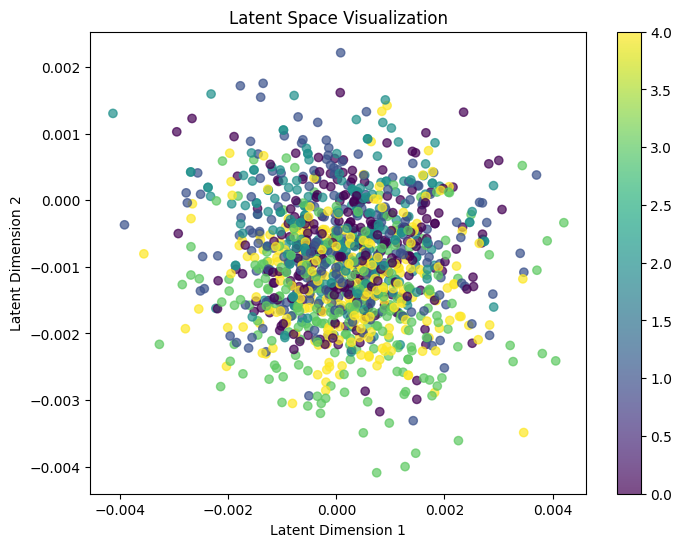

In [33]:
visualize_latent_space(vae, dinov2_model, val_loader, device)